# Part 1 - General Concept of the process
## Imports
___ 

In [6]:
import os
from scipy import signal
import numpy as np
from scipy.io import wavfile
from matplotlib import pyplot as plt
import IPython.display as ipd
import operator
from scipy.interpolate import interp1d
import librosa
import tikzplotlib 

## Basic Wave


In [7]:
raw_freq, raw_amp = wavfile.read(os.path.join('data','noisy_sequence_500_ms.wav'))
raw_amp = raw_amp.astype(np.int32) # Prevent overflow later noisy_sequence_500_ms

print(len(raw_amp))
ipd.display(ipd.Audio(data=raw_amp, rate=raw_freq))

417024


___
## Taking a sample

In the sample below I am basically taking a small part of the original graph and creating a sub sound, 

This is to isolate a single DTMF signal so its more managable


### NoteSome Good Frequency ranges:

* 10000:20000   - basic first signal (easy)
* 2000:4000     - sparse frequencies (very short time)
* 21000:30000   - Between 2 frequincy ranges no matching signal

Note you will notice that if you try the case with 2 frequencies apearing there will most likely be 2 of the same
frequencies or 2 column values or 2 row values, in other words we cannot map them in the table

This is good as it gives us another chase to notice when we are switching between signals

___

In [8]:
amp_sample = raw_amp[30000:40000]
ipd.display(ipd.Audio(data=amp_sample, rate=raw_freq))

amp_fourier     = np.fft.fft(amp_sample,norm='forward')
freq_fourier    = np.fft.fftfreq(len(amp_fourier), 1/raw_freq)

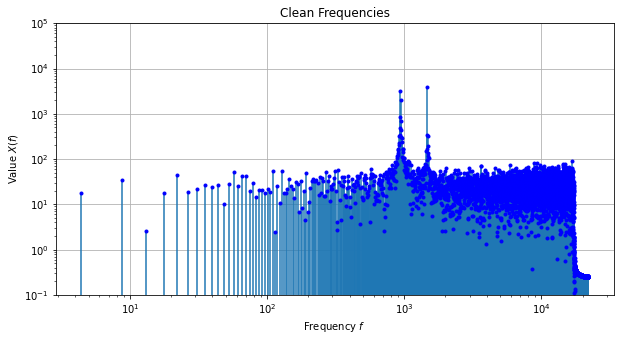

In [9]:
plt.figure(figsize=(10, 5), facecolor='white')
plt.stem(np.fft.fftshift(freq_fourier),np.fft.fftshift(np.abs(amp_fourier)),markerfmt='b.')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,1e5)
plt.grid(True)
plt.xlabel('Frequency $f$')
plt.ylabel('Value $X(f)$')
plt.title('Clean Frequencies')
plt.show()

___
## Filtering

As you can see above, even though this is a "clean" signal meaning there is no noise, there are still multiple frequencies that make up the wave.

I think these are since the sound technically starts on low amplitude goes slightly higher and then goes back to a low amplitude before the signal is done,
meaning it starts slighly soft, gets louder, then goes back to soft.

So what i did is add a funcion that given a margin of error we can split the frequency range into accaptable "columns"

Now this will have the added benfits of both making it esear to narrow down the frequency ranges, AND reduce the noise when we have noisy signals

___

In [10]:
def filter_dtmf_frequencies(amplitudes, frequencies, error_margin=0):
    filtered_indices = []

    for i, freq in enumerate(frequencies):
        if (697 - error_margin) <= freq <= (697 + error_margin):
            filtered_indices.append(i)
        elif (770 - error_margin) <= freq <= (770 + error_margin):
            filtered_indices.append(i)
        elif (852 - error_margin) <= freq <= (852 + error_margin):
            filtered_indices.append(i)
        elif (941 - error_margin) <= freq <= (941 + error_margin):
            filtered_indices.append(i)
        elif (1209 - error_margin) <= freq <= (1209 + error_margin):
            filtered_indices.append(i)
        elif (1336 - error_margin) <= freq <= (1336 + error_margin):
            filtered_indices.append(i)
        elif (1477 - error_margin) <= freq <= (1477 + error_margin):
            filtered_indices.append(i)
    
    # Extract filtered amplitudes and frequencies
    filtered_amplitudes = [amplitudes[i] for i in filtered_indices]
    filtered_frequencies = [frequencies[i] for i in filtered_indices]
    
    return filtered_frequencies, filtered_amplitudes

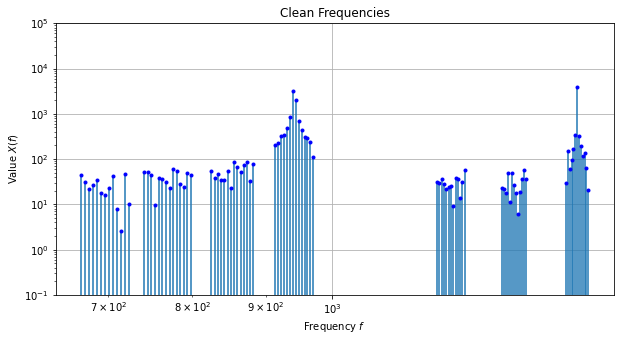

In [11]:

filtered_freq_fourier, filtered_amp_fourier = filter_dtmf_frequencies(amp_fourier, freq_fourier, 30)

plt.figure(figsize=(10, 5), facecolor='white')
plt.stem(np.fft.fftshift(filtered_freq_fourier),np.fft.fftshift(np.abs(filtered_amp_fourier)),markerfmt='b.')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,1e5)
plt.grid(True)
plt.xlabel('Frequency $f$')
plt.ylabel('Value $X(f)$')
plt.title('Clean Frequencies')
plt.show()

___
## Results Analysis

Here in the below function i check which are the 2 highest values:

* First i ignore the negative frequencies since there for example would be both a + and - 941 for example
* then we obtain the 2 greatest values, not sure how it does it - ask gpt

In [12]:
def find_top_frequencies(amp, freq, N=4):
    # Zip A and B together
    zipped = list(zip(freq, amp))
    # Sort the zipped list based on the absolute values of elements in B
    sorted_zipped = sorted(zipped, key=lambda x: abs(x[1]), reverse=True)
    # Extract the first N elements
    top_n = sorted_zipped[:N]
    # Unzip to separate A and B
    result_freq, result_amp = zip(*top_n)
    return result_freq, result_amp

In [13]:

top_frequencies, top_amplitudes = find_top_frequencies(amp_fourier, freq_fourier, 4)
for i in range(4):
    real_part = round(top_amplitudes[i].real, 3)
    imag_part = round(top_amplitudes[i].imag, 3)
    print("AMP[{}] = {: .3f} + {: .3f}j,\t Freq[{}] = {: .3f}".format(i, real_part, imag_part, i, top_frequencies[i]))

AMP[0] = -3901.957 +  863.248j,	 Freq[0] =  1477.350
AMP[1] = -3901.957 + -863.248j,	 Freq[1] = -1477.350
AMP[2] = -3198.281 +  48.170j,	 Freq[2] =  939.330
AMP[3] = -3198.281 + -48.170j,	 Freq[3] = -939.330


___
## Suggestions

Now as you saw before the frequincies are split into columns, somthing we could do with might help, is either:
* Adding all the amplitudes for each column and then check for the heighest sum
* Calculate the average instead and compare those
* Calculate the mean (might be more stable whith the noise outliers but i doubt it would do much with such small values)

iether might work if you have other suggestions go ahead
___

# Part 2 - Taking 32 set samples at 6000 frequencies

Below is the raw data we have to work with

In [14]:
sample_rate = 6000
num_samples = 32

step_size = raw_freq/sample_rate

print("Number of Raw Samples        : ",len(raw_amp))
print("Raw Frequency                : ",raw_freq)
print("Frequency to sample by       : ",sample_rate)
print("Jump size to read at 6000Hz  : ",step_size)

Number of Raw Samples        :  417024
Raw Frequency                :  44100
Frequency to sample by       :  6000
Jump size to read at 6000Hz  :  7.35


If you don't understand what I mean by "step/jump size" imagine the following:

This is the raw array of values and the value shown as $<number>$ is the index at that position:

$$[<0>,\ <1>,\ <2>,\ <3>,\ <4>,\ <5>,\ <6>,\ <7>,..................... <425088>]$$

Now the issue is that what we will be sampling from is not an audio signal but an array which was itself sampled at a sampling rate of around 40,000 Hz so we need to see how large of jumps we can take so that we can convert to a 6,000 Hz sample. so we would get somthing like this (since the step size is 7)

$$[<0>,\ <7>,\ <14>,\ <21>, ..................... <224>]$$

## Take a sample Set

The function below takes 32 sample and returns an array

In [15]:
def sample_audio(raw_data, start_index, sample_rate=6000, num_samples=32):
    """
    Function to sample audio data from a given starting point at a specified sampling rate.
    
    Parameters:
        raw_data (numpy.ndarray): Raw audio data.
        start_index (int): Starting index for sampling.
        sample_rate (int, optional): Sampling rate. Default is 6000 Hz.
        num_samples (int, optional): Number of samples to take. Default is 32.
    
    Returns:
        numpy.ndarray: Sampled audio data.
    """
    step_size = int(raw_freq / sample_rate)
    sampled_data = raw_data[start_index::step_size][:num_samples]
    return sampled_data


## Visualization

This function gives a visual of the range from which the sample starts (from a given start index) and till where the last sample of the number of sample will be taken from.

In [16]:
import matplotlib.pyplot as plt

def plot_sample_range(raw_data, start_index, sample_rate=6000, num_samples=32):
    """
    Function to plot either the range of samples or the entire raw audio graph.

    Parameters:
        raw_data (numpy.ndarray): Raw audio data.
        start_index (int): Starting index for sampling.
        sample_rate (int, optional): Sampling rate. Default is 6000 Hz.
        num_samples (int, optional): Number of samples to take. Default is 32.
        plot_entire (bool, optional): Whether to plot the entire raw audio graph. Default is False.
    """
    # --------------------------------------------------- Calculating the step size
    step_size = int(raw_freq / sample_rate)

    # --------------------------------------------------- Calculat sample range
    sampled_data = raw_data[start_index::step_size][:num_samples]
    sample_end = start_index + step_size * (num_samples - 1)

    # ---------------------------------------------------  Plot
    plt.figure(figsize=(20, 5), facecolor='white')   
    
    # --------------------------------------------------- Sub Plot 1 : Entire Audio Signal
    plt.subplot (1, 2, 1)

    plt.title   ('Entire Raw Audio')
    plt.ylabel  ('Amplitude')
    plt.xlabel  ('Sample Index')
    plt.plot    (raw_data, label='Entire Raw Audio', color = 'royalblue')
    plt.axvspan (start_index, sample_end, color='crimson', alpha=0.3, label='Sampled Range')

    plt.legend  (loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

    # --------------------------------------------------- Sub Plot 2 : Zoomed In
    plt.subplot (1, 2, 2)

    plt.title   ('Zoomed In Sample range')
    plt.ylabel  ('Amplitude')
    plt.xlabel  ('Sample Index')
    plt.plot    (raw_data, label='Original Audio', color = 'royalblue')
    plt.axvspan (start_index, sample_end, color='crimson', alpha=0.3, label='Sampled Range')
    plt.xlim    (start_index-100, sample_end+100)

    plt.legend  (loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

    
    # --------------------------------------------------- Plot
    plt.tight_layout()
    plt.show()


### Examples

Note the little red line on the left graph is the zoomed out vairent of the left graph

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  1  1  3  0 -2
 -2  0 -2 -5  4  5 17  4]


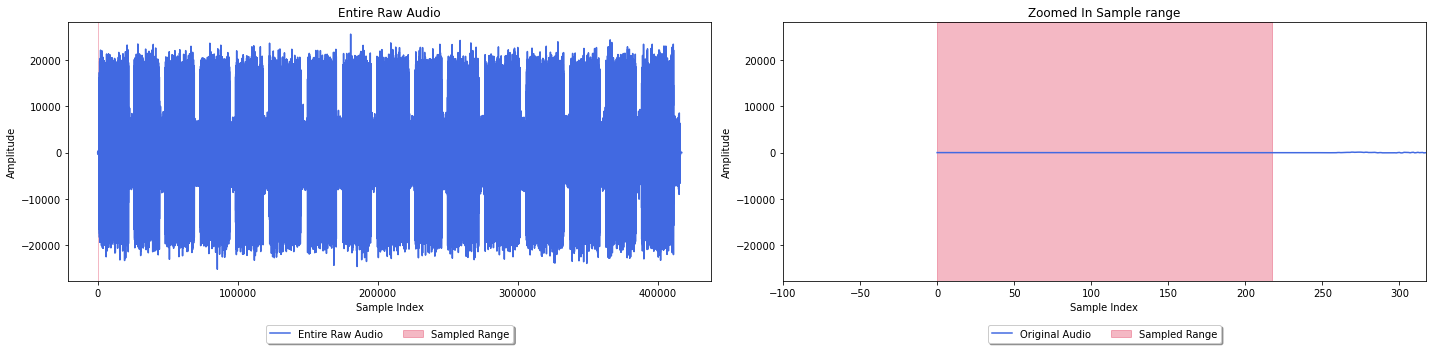

NameError: name 'matplotlib2tikz' is not defined

In [17]:
sample_rate = 6000
num_samples = 32

print   ( sample_audio  (   raw_data = raw_amp, 
                            start_index = 0, 
                            sample_rate=sample_rate, 
                            num_samples=num_samples
                        )
        )

plot_sample_range   (   
                        raw_data    = raw_amp,
                        start_index = 0,
                        sample_rate = sample_rate,
                        num_samples = num_samples,
                    )

                    
tikzplotlib.get_tikz_code()


[-10527    314  14213  16837    825 -13440  -2153  -1953   4116   5809
   3525   2397   -311    717  -8806  -7352   3400  12559  11476  -5075
 -14651 -11255   8803  20501  11562  -7877 -14191  -6333   5635  13326
   4545  -3795]


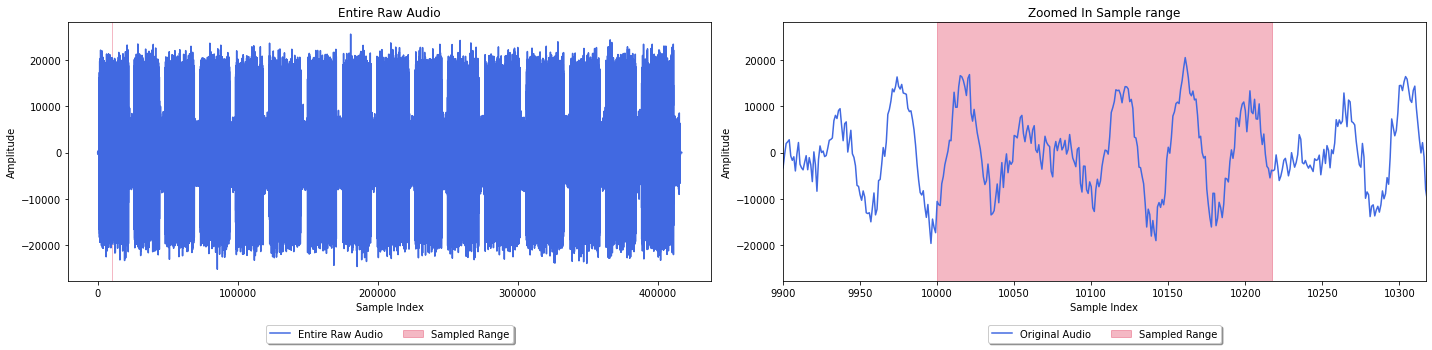

In [ ]:
print   ( sample_audio  (   raw_data = raw_amp, 
                            start_index = 10000, 
                            sample_rate=sample_rate, 
                            num_samples=num_samples
                        )
        )

plot_sample_range   (   
                        raw_data    = raw_amp,
                        start_index = 10000,
                        sample_rate = sample_rate,
                        num_samples = num_samples,
                    )

## Circuit Simulation

The function Below simultaes how the circuit will transform the line level input into ADC

In [ ]:
def shift_and_scale_amplitude(raw_amp, min = 0, max = 3.3):
    """
    Shifts the amplitude array to have a minimum amplitude of 0 and scales it to have a maximum amplitude of 3.3.

    Parameters:
        raw_amp (numpy.ndarray): Raw amplitude array.

    Returns:
        numpy.ndarray: Shifted and scaled amplitude array.
    """
    min_amp = np.min(raw_amp)
    
    # ------------------------------------- Shift Up
    shifted_amp = raw_amp + abs(min_amp) - min
    
    # ------------------------------------- Scale
    max_amp = np.max(shifted_amp)
    scaled_amp = (shifted_amp / max_amp) * max

    # ------------------------------------- Plot
    plt.figure(figsize=(20, 5), facecolor='white')

    plt.subplot (1, 2, 1)
    plt.plot    (raw_amp, label='Raw Graph', color='crimson')
    plt.xlabel  ('Sample Index')
    plt.ylabel  ('Amplitude')
    plt.title   ('Original Plot')
    plt.legend  (loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    
    plt.subplot (1, 2, 2)
    plt.plot    (scaled_amp, label='Shifted and Scaled Amplitude', color='royalblue')
    plt.xlabel  ('Sample Index')
    plt.ylabel  ('Amplitude')
    plt.title   ('Shifted/Scaled Plot')
    plt.legend  (loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
    
    plt.show()

    return scaled_amp

### Example

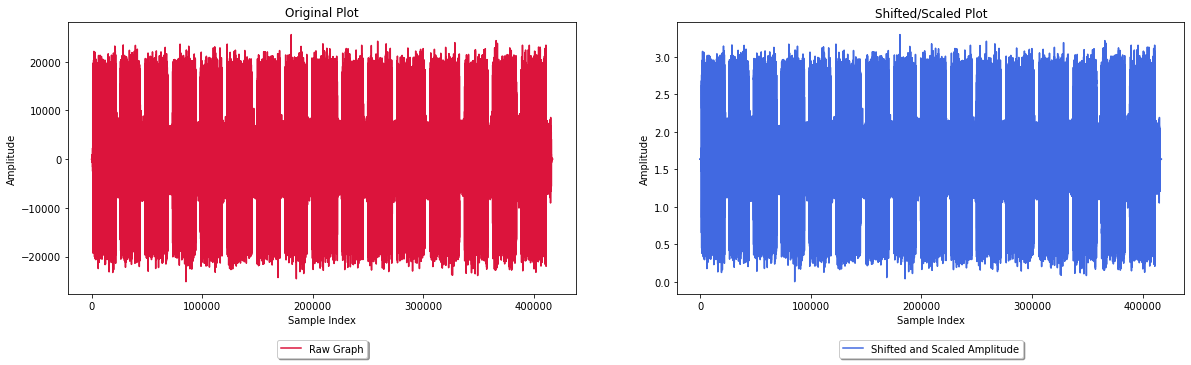

In [ ]:
scaled_amp = shift_and_scale_amplitude(raw_amp)

## Simulation

From here we have everything to create a proper simulation 

In [ ]:
sample_freq     = 42000
sampe_amount    = 2048
sample_pos      = 0

### First - take take a smaller sample

In [ ]:
amp_sample_scaled = scaled_amp[60000:70000]
ipd.display(ipd.Audio(data=amp_sample_scaled, rate=raw_freq))

#### Testing the Scaled Frequency For Reference

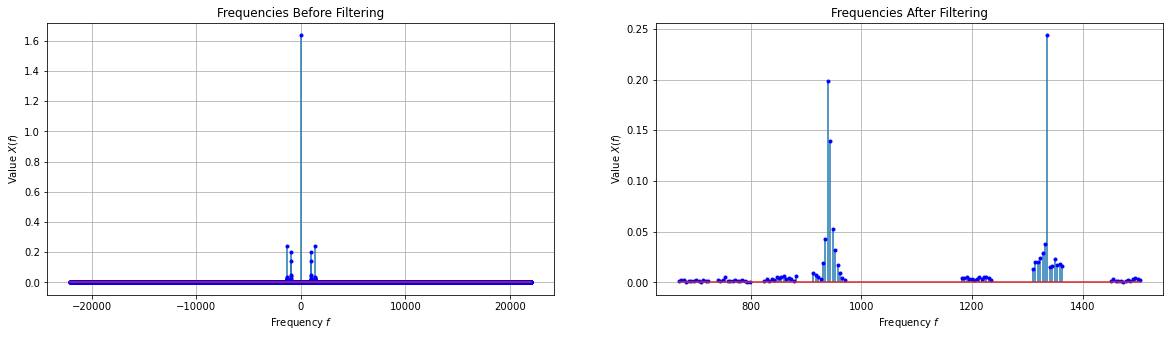

AMP[0] =  0.224 + -0.095j,	 Freq[0] =  1336.230
AMP[1] = -0.151 + -0.130j,	 Freq[1] =  939.330
AMP[2] =  0.073 +  0.119j,	 Freq[2] =  943.740
AMP[3] =  0.015 +  0.050j,	 Freq[3] =  948.150


In [ ]:
amp_test  = np.fft.fft        (amp_sample_scaled,norm='forward')
freq_test = np.fft.fftfreq    (len(amp_sample_scaled), 1/raw_freq)

plt.figure(figsize=(20, 5), facecolor='white')

plt.subplot (1, 2, 1)
plt.stem(np.fft.fftshift(freq_test),np.fft.fftshift(np.abs(amp_test)),markerfmt='b.')
plt.grid(True)
plt.xlabel('Frequency $f$')
plt.ylabel('Value $X(f)$')
plt.title('Frequencies Before Filtering')


fil_test_f, fil_test_a = filter_dtmf_frequencies(amp_test, freq_test, 30)

plt.subplot (1, 2, 2)
plt.stem(np.fft.fftshift(fil_test_f),np.fft.fftshift(np.abs(fil_test_a)),markerfmt='b.')
plt.grid(True)
plt.xlabel('Frequency $f$')
plt.ylabel('Value $X(f)$')
plt.title('Frequencies After Filtering')
plt.show()

result_Freq, result_Amp = find_top_frequencies(fil_test_a, fil_test_f, 4)
for i in range(4):
    real_part = round(result_Amp[i].real, 3)
    imag_part = round(result_Amp[i].imag, 3)
    print("AMP[{}] = {: .3f} + {: .3f}j,\t Freq[{}] = {: .3f}".format(i, real_part, imag_part, i, result_Freq[i]))

    



### Second - Take the 32 samples at 6000 Hz

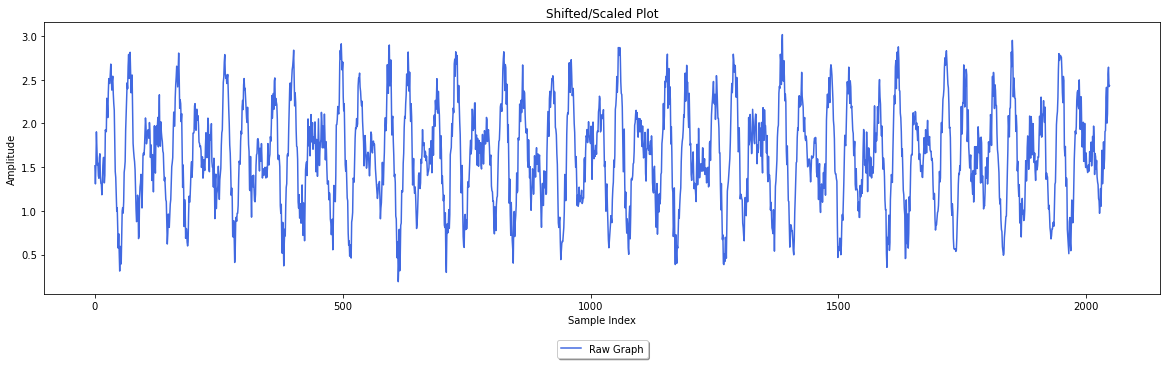

In [ ]:
sample = sample_audio   (   raw_data    = amp_sample_scaled, 
                            start_index = sample_pos, 
                            sample_rate = sample_freq, 
                            num_samples = sampe_amount
                        )
plt.figure  (figsize=(20, 5), facecolor='white')
plt.plot    (sample, label='Raw Graph', color='royalblue')
plt.xlabel  ('Sample Index')
plt.ylabel  ('Amplitude')
plt.title   ('Shifted/Scaled Plot')
plt.legend  (loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)
plt.show()

Frequency-Amplitude Pairs:
(697, 0.006238545541949606)
(770, 0.010601863565347992)
(852, 0.030832065687955754)
(941, 0.0319849987561774)
(1209, 0.003695837581021535)
(1336, 0.005580370649624407)
(1477, 0.002723646086837624)
(1633, 0.0034245215169642932)


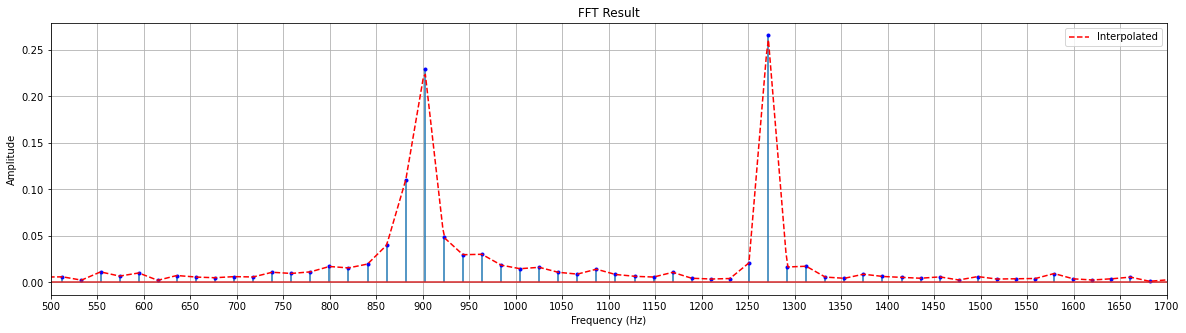

In [ ]:
amp_fourier_sample  = np.fft.fft(sample,norm='forward')
freq_fourier_sample = np.fft.fftfreq(len(sample), 1/sample_freq)

def interpolate_amplitudes_for_frequencies(frequencies, amp_ft, freq_ft):
    # Remove negative frequencies and their amplitudes
    positive_freq_indices = np.array(freq_ft) > 0
    amp_ft_positive     = np.array(amp_ft)  [positive_freq_indices]
    freq_ft_positive    = np.array(freq_ft) [positive_freq_indices]

    # Interpolate amplitude
    interpolator = interp1d(freq_ft_positive, np.abs(amp_ft_positive), kind='linear', fill_value="extrapolate")
    
    # Get interpolated amplitudes for the given frequencies
    interpolated_amplitudes = interpolator(frequencies)
    
    # Create pairs of frequencies and interpolated amplitudes
    freq_amp_pairs = list(zip(frequencies, interpolated_amplitudes))
    
    return freq_amp_pairs



frequencies_of_interest = [697, 770, 852, 941, 1209, 1336, 1477, 1633]
freq_amp_pairs = interpolate_amplitudes_for_frequencies(frequencies_of_interest, amp_fourier_sample, freq_fourier_sample)

# Print the frequency-amplitude pairs
print("Frequency-Amplitude Pairs:")
for pair in freq_amp_pairs:
    print(pair)


# Remove negative frequencies and their amplitudes
positive_freq_indices = np.array(freq_fourier_sample) > 0
amp_ft_positive = np.array(amp_fourier_sample)[positive_freq_indices]
freq_ft_positive = np.array(freq_fourier_sample)[positive_freq_indices]

# Interpolate amplitude
interpolator = interp1d(freq_ft_positive, np.abs(amp_ft_positive), kind='linear', fill_value="extrapolate")

# Interpolated frequencies
freq_interpolated = np.linspace(min(freq_ft_positive), max(freq_ft_positive), 10000)

# Plotting
plt.figure(figsize=(20, 5), facecolor='white')
plt.stem(freq_ft_positive, np.abs(amp_ft_positive), markerfmt='b.')
plt.plot(freq_interpolated, interpolator(freq_interpolated), label='Interpolated', color='red', linestyle='dashed')
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Result')
plt.legend()
plt.xlim(500, 1700)
# Increase x-spacing
plt.locator_params(axis='x', nbins=40)  # Adjust nbins as needed

plt.show()

#### What we are Sampling

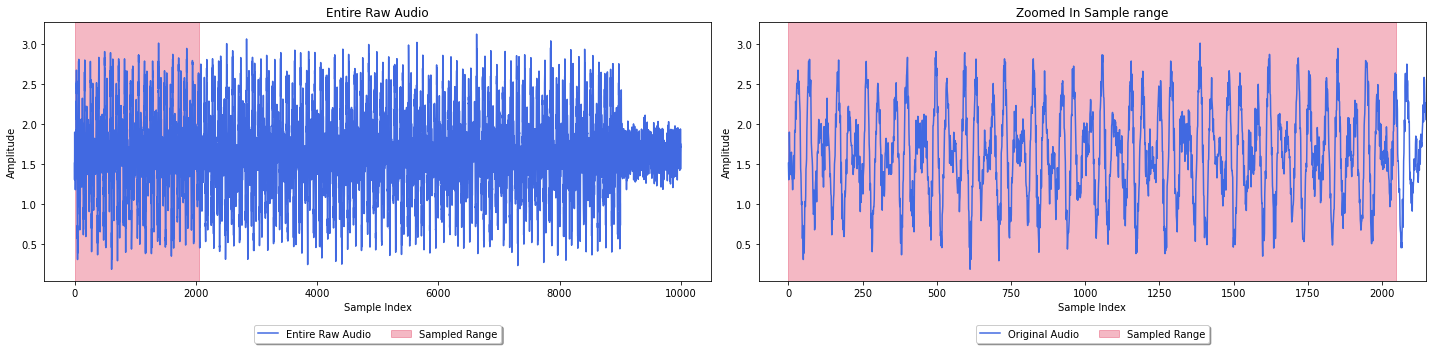

In [ ]:
plot_sample_range       (   raw_data    = amp_sample_scaled, 
                            start_index = sample_pos, 
                            sample_rate = sample_freq, 
                            num_samples = sampe_amount
                        )

### Raw Fourier of sample

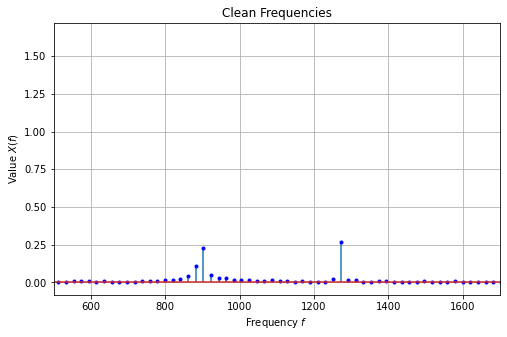

2048
AMP[0] =  1.637 +  0.000j,	 Freq[0] =  0.000
AMP[1] =  0.264 + -0.033j,	 Freq[1] =  1271.484
AMP[2] =  0.264 +  0.033j,	 Freq[2] = -1271.484
AMP[3] = -0.053 +  0.223j,	 Freq[3] =  902.344


In [ ]:
amp_fourier_sample  = np.fft.fft(sample,norm='forward')
freq_fourier_sample = np.fft.fftfreq(len(sample), 1/sample_freq)

plt.figure(figsize=(8, 5), facecolor='white')
plt.stem(np.fft.fftshift(freq_fourier_sample),np.fft.fftshift(np.abs(amp_fourier_sample)),markerfmt='b.')
plt.grid(True)
plt.xlabel('Frequency $f$')
plt.ylabel('Value $X(f)$')
plt.title('Clean Frequencies')

plt.xlim(500, 1700)
plt.show()

print(len(freq_fourier_sample))

result_Freq, result_Amp = find_top_frequencies(amp_fourier_sample, freq_fourier_sample, 4)
for i in range(4):
    real_part = round(result_Amp[i].real, 3)
    imag_part = round(result_Amp[i].imag, 3)
    print("AMP[{}] = {: .3f} + {: .3f}j,\t Freq[{}] = {: .3f}".format(i, real_part, imag_part, i, result_Freq[i]))

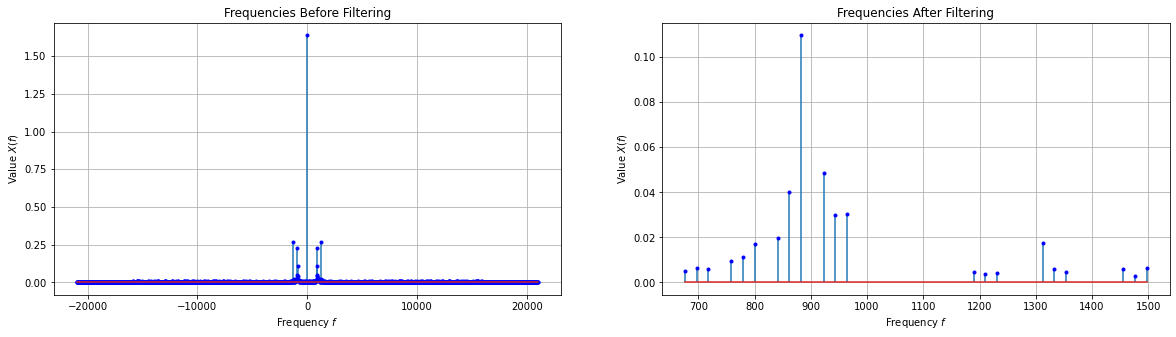

In [ ]:
amp_ft  = np.fft.fft        (sample,norm='forward')
freq_ft = np.fft.fftfreq    (len(sample), 1/sample_freq)

plt.figure(figsize=(20, 5), facecolor='white')

plt.subplot (1, 2, 1)
plt.stem(np.fft.fftshift(freq_ft),np.fft.fftshift(np.abs(amp_ft)),markerfmt='b.')
plt.grid(True)
plt.xlabel('Frequency $f$')
plt.ylabel('Value $X(f)$')
plt.title('Frequencies Before Filtering')

fil_test_f, fil_test_a = filter_dtmf_frequencies(amp_ft, freq_ft, 30)

plt.subplot (1, 2, 2)
plt.stem(np.fft.fftshift(fil_test_f),np.fft.fftshift(np.abs(fil_test_a)),markerfmt='b.')
plt.grid(True)
plt.xlabel('Frequency $f$')
plt.ylabel('Value $X(f)$')
plt.title('Frequencies After Filtering')
plt.locator_params(axis='x', nbins=10)
plt.show()



In [ ]:
def interpolate_amplitudes_for_frequencies(frequencies, amp_ft, freq_ft):
    # Remove negative frequencies and their amplitudes
    positive_freq_indices = np.array(freq_ft) > 0
    amp_ft_positive     = np.array(amp_ft)  [positive_freq_indices]
    freq_ft_positive    = np.array(freq_ft) [positive_freq_indices]

    # Interpolate amplitude
    interpolator = interp1d(freq_ft_positive, np.abs(amp_ft_positive), kind='linear', fill_value="extrapolate")
    
    # Get interpolated amplitudes for the given frequencies
    interpolated_amplitudes = interpolator(frequencies)
    
    # Create pairs of frequencies and interpolated amplitudes
    freq_amp_pairs = list(zip(frequencies, interpolated_amplitudes))
    
    return freq_amp_pairs

Frequency-Amplitude Pairs:
(697, 0.006238545541949606)
(770, 0.010601863565347992)
(852, 0.030832065687955754)
(941, 0.0319849987561774)
(1209, 0.003695837581021535)
(1336, 0.005580370649624407)
(1477, 0.002723646086837624)
(1633, 0.0034245215169642932)


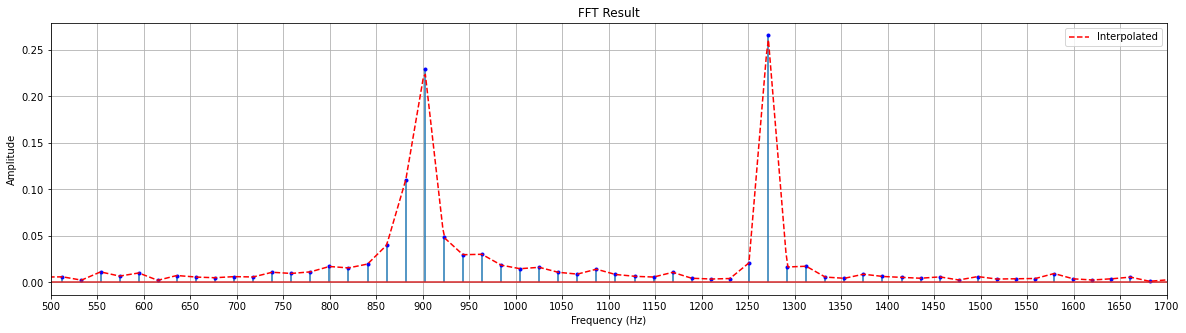

In [ ]:



frequencies_of_interest = [697, 770, 852, 941, 1209, 1336, 1477, 1633]
freq_amp_pairs = interpolate_amplitudes_for_frequencies(frequencies_of_interest, amp_ft, freq_ft)

# Print the frequency-amplitude pairs
print("Frequency-Amplitude Pairs:")
for pair in freq_amp_pairs:
    print(pair)


# Remove negative frequencies and their amplitudes
positive_freq_indices = np.array(freq_ft) > 0
amp_ft_positive = np.array(amp_ft)[positive_freq_indices]
freq_ft_positive = np.array(freq_ft)[positive_freq_indices]

# Interpolate amplitude
interpolator = interp1d(freq_ft_positive, np.abs(amp_ft_positive), kind='linear', fill_value="extrapolate")

# Interpolated frequencies
freq_interpolated = np.linspace(min(freq_ft_positive), max(freq_ft_positive), 10000)

# Plotting
plt.figure(figsize=(20, 5), facecolor='white')
plt.stem(freq_ft_positive, np.abs(amp_ft_positive), markerfmt='b.')
plt.plot(freq_interpolated, interpolator(freq_interpolated), label='Interpolated', color='red', linestyle='dashed')
plt.grid(True)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('FFT Result')
plt.legend()
plt.xlim(500, 1700)
# Increase x-spacing
plt.locator_params(axis='x', nbins=40)  # Adjust nbins as needed

plt.show()

### Results

In [ ]:
result_Freq, result_Amp = find_top_frequencies(amp_ft, freq_ft, 10)
for i in range(10):
    real_part = round(result_Amp[i].real, 3)
    imag_part = round(result_Amp[i].imag, 3)
    print("AMP[{}] = {: .3f} + {: .3f}j,\t Freq[{}] = {: .3f}".format(i, real_part, imag_part, i, result_Freq[i]))

AMP[0] =  1.637 +  0.000j,	 Freq[0] =  0.000
AMP[1] =  0.264 + -0.033j,	 Freq[1] =  1271.484
AMP[2] =  0.264 +  0.033j,	 Freq[2] = -1271.484
AMP[3] = -0.053 +  0.223j,	 Freq[3] =  902.344
AMP[4] = -0.053 + -0.223j,	 Freq[4] = -902.344
AMP[5] =  0.030 +  0.106j,	 Freq[5] = -881.836
AMP[6] =  0.030 + -0.106j,	 Freq[6] =  881.836
AMP[7] = -0.019 +  0.045j,	 Freq[7] =  922.852
AMP[8] = -0.019 + -0.045j,	 Freq[8] = -922.852
AMP[9] =  0.008 +  0.039j,	 Freq[9] = -861.328
